In [2]:
import sys

import pickle
import numpy as np

import os
import warnings

import matplotlib as mpl
from matplotlib import pyplot as plt

from collections import defaultdict as ddict
from collections import OrderedDict as odict
from collections import namedtuple as nt
from scipy.optimize import minimize_scalar
from scipy.optimize import root
from math import erf

from scipy import stats
from scipy.integrate import quad
from scipy.optimize import broyden1 as minimize
from scipy.interpolate import interp1d
from scipy.integrate import simpson
from scipy.special import dawsn
from scipy.special import erfi
from scipy.optimize import root

from scipy import stats
from copy import deepcopy


In [3]:
def variance_star(S,x):
    return 2*S*x*(1-x)

def folded_sojourn_time(S,x,N=5000):
    if x < 0:
        raise ValueError
    elif x > 1/2:
        raise ValueError
    else:
        value = 2 * np.exp(-variance_star(S=S,x=x)/2) / (x * (1 - x))
        if x <= 1/(2*N):
            return 2 * N * x * value
        else:
            return value


In [4]:
def establishment_prob(S,shift,x,sign=1):
    a = np.sqrt(S)*sign
    Sx = lambda x: a*(shift-a*(1/2-x))/(2*N)
    if Sx(x) < 0: return 0
    establishment_prob_l = lambda x: (1 - np.exp(-4*N*Sx(x)*x))/(1 - np.exp(-4*N*Sx(x)))
    return establishment_prob_l(x)

def critical_xc_establishment_prob(S,shift,xc):
    numerator = quad(lambda x: folded_sojourn_time(S=S,x = x)*establishment_prob(S=S,shift=shift, x = x),xc,1/2,points=[1/(2*N)])[0]
    denominator = quad(lambda x: folded_sojourn_time(S=S,x = x),0,1/2,points=[1/(2*N)])[0]
    return numerator/denominator

def find_xc_for_establishment(threshold,S,shift):
    
    max_establishment_prob = critical_xc_establishment_prob(S=S,shift=shift,xc=0)
    if max_establishment_prob<threshold:
        return np.nan
    sol = root(lambda xc: critical_xc_establishment_prob(S=S,shift=shift,xc=xc)-threshold,x0=1/(2*N))
    return sol.x[0]


In [6]:
with open('/burg-archive/home/wm2377/cdwm/snakemake_versions/Figure_S11/results/all_results.pickle','rb') as fin:
    simulated_results = pickle.load(fin)

for shift in simulated_results:
    for sigma2 in simulated_results[shift]:
        for S in simulated_results[shift][sigma2]:
            for sign in simulated_results[shift][sigma2][S]:
                n = 0
                n_fix = 0
                for x_trajectory in simulated_results[shift][sigma2][S][sign].values():
                    if x_trajectory[-1] == 1:
                        n_fix += 1
                    n += 1
                simulated_results[shift][sigma2][S][sign] = (n_fix,n)


In [7]:
def get_recursion2(S,x0,D0,sigma2,fix_freq=0.5,N=5000):
    
    x = x0
    D = D0
    a = np.sqrt(S)
    t = 0
    Vs = 2*N
    
    while x<fix_freq:

        dx = a/Vs*x*(1-x)*(D-a*(1/2-x)*(1-D**2/Vs))
        
#         dx = a/Vs*x*(1-x)*(D)
        if dx < 0: 
            return 0
        
        x += dx
        D += - D/Vs*sigma2 - 2*a*dx
        t += 1
        
        if D < 0.5:
            return 0

    if x < fix_freq: 
        return 0
    else: 
        return 1

def find_minimum_frequency_for_shift_recursion(sigma2,S,shift,x0,depth,best_guess):
    if depth == 50: 
        return best_guess
    
    fix_x0 = get_recursion2(S=S,x0=x0,D0=shift,sigma2=sigma2)
    if fix_x0:
        if x0 < best_guess:
            best_guess = x0
        return find_minimum_frequency_for_shift_recursion(sigma2=sigma2,S=S,shift=shift,x0=x0-1/2**(depth+1),depth=depth+1,best_guess=best_guess)
    else:
        return find_minimum_frequency_for_shift_recursion(sigma2=sigma2,S=S,shift=shift,x0=x0+1/2**(depth+1),depth=depth+1,best_guess=best_guess)
    
def calculate_recursion_fixation_probability(sigma2,S,shift,adaptation=False,sign=1):
    if sign == -1:
        min_x = 1/2
    else:
        min_x = find_minimum_frequency_for_shift_recursion(sigma2=sigma2,S=S,shift=shift,x0=0.5,depth=1,best_guess=0.5)
    bottom = quad(lambda x: folded_sojourn_time(S=S,x=x),0,1/2,points=[1/(2*N)])[0]
    a = np.sqrt(S)
#     if min_x < 1/(a*(shift-a*(1/2))):
#         min_x = 0
        
    if adaptation == False:
        top = quad(lambda x: folded_sojourn_time(S=S,x=x)*establishment_prob(S=S,shift=shift,x=x),min_x,1/2,points=[1/(2*N),2/(2*N)])[0]
        return top/bottom
    else:
        fixations = quad(lambda x: 2*np.sqrt(S)*(1-x)*folded_sojourn_time(S=S,x=x)*establishment_prob(S=S,shift=shift,x=x),min_x,1/2,points=[1e-4])[0]
        extinctions = 0#quad(lambda x: 2*np.sqrt(S)*sign*(-x)*folded_sojourn_time(S=S,x=x),0,min_x,points=[1e-4])[0]
        return (fixations+extinctions)/bottom
    

In [8]:

def fixation_prob_(S,x,sign,sigma2,shift,mode,b=np.nan):
    a = np.sqrt(S)*sign
#     dx = shift/sigma2*(S*x*(1-x)/(a))
    if 'uber_simple' in mode:
        dx = x*(1-x)*a*(shift/sigma2)
    else:
        dx = a*fd_new(S,sign,sigma2,shift,x,mode,b=b)*x*(1-x)
    xx = min(1,max(0,x + dx))
    fix = (erf(a/2) - erf(a/2*(1 - 2*xx)))/(2*erf(a/2))
    if 'establishment' in mode:
        fix = fix * establishment_prob(S,shift,x,sign)
#         cep = complicated_establish_prob(S=S,shift=shift,sigma2=sigma2,x=x)
#         fix = fix * cep
#         if np.isnan(cep):
#             print(cep,establishment_prob(S,shift,x),x,S,sigma2,shift)
        
    return fix

def fixation_prob_given_S(S,sign,sigma2,shift,mode,adaptation=False,b=np.nan):
    bottom = quad(lambda x: folded_sojourn_time(S=S,x=x),0,1/2,points=[1e-4])[0]
    if adaptation == False:
        top = quad(lambda x: folded_sojourn_time(S=S,x=x)*fixation_prob_(S,x,sign,sigma2,shift,mode,b=b),0,1/2,points=[1e-4])[0]
        return top/bottom
    else:
        fixations = quad(lambda x: 2*np.sqrt(S)*(1-x)*folded_sojourn_time(S=S,x=x)*fixation_prob(S,x,sign,sigma2,shift,mode,b=b),0,1/2,points=[1e-4])[0]
        extinctions = 0#quad(lambda x: 2*np.sqrt(S)*sign*(-x)*folded_sojourn_time(S=S,x=x)*(1-fixation_prob(S,x,sign,sigma2,shift)),0,1/2,points=[1e-4])[0]
        return (fixations+extinctions)/bottom

def fd(S,sign,sigma2,shift,x):
    a = np.sqrt(S)*sign
    useful = np.exp(a*shift/sigma2)-1
    return 1/a*useful/(1+x*useful)

def fd_new(S,sign,sigma2,shift,x,mode,b=np.nan):
    a = np.sqrt(S)*sign
    if np.isnan(b):
        if 'ss' in mode:
            t = np.log(shift)*2*N/sigma2
            directional = S_d(a=a,shift=shift,V_A=sigma2,t=t,x_0=x)
            stabilizing = S_s(a=a,shift=shift,V_A=sigma2,t=t,x_0=x)
            b = (directional+stabilizing)*t/a
        else:
            b = shift/sigma2
    useful = np.exp(a*b)-1
    return 1/a*useful/(1+x*useful)




In [9]:
def S_s(a,shift,V_A,t,x_0,V_S=1e4):
    x=x_0
    g = -a**2/V_S*((1/2-x_0)*(1-DL2_bar(a,shift,V_A,t,x_0,V_S)/V_S)-a*x*(1-x)*(ID(a,shift,V_A,t,x_0,V_S)-a*(1/2-x_0)*IS(a,shift,V_A,t,x_0,V_S)))
    return g
                    
def ID(a,shift,V_A,t,x_0,V_S=1e4):
    return shift/V_A*(1-DL_bar(a,shift,V_A,t,x_0,V_S)/shift*(1+1/6*shift**2/V_S*(1-DL(a,shift,V_A,t,x_0,V_S)/shift)*(1+2*DL(a,shift,V_A,t,x_0,V_S)/shift)))
#     return shift/Va*(1-DL(t)/shift)

def IS(a,shift,V_A,t,x_0,V_S=1e4):
    return 1/2*t/(2*V_S)*(1-DL2_bar(a,shift,V_A,t,x_0,V_S)/V_S*(2-DL2_bar(a,shift,V_A,t,x_0,V_S)/V_S))

def DL(a,shift,V_A,t,x_0,V_S=1e4):
    return shift*np.exp(-t*V_A/V_S)

def DL_bar(a,shift,V_A,t,x_0,V_S=1e4):
    return shift/V_A*(1-DL(a,shift,V_A,t,x_0,V_S)/shift)*V_S/t

def DL2_bar(a,shift,V_A,t,x_0,V_S=1e4):
    return 1/2*shift**2/(V_A)*(1-(DL(a,shift,V_A,t,x_0,V_S)**2)/shift**2)/t

def S_d(a,shift,V_A,t,x_0,V_S=1e4):
    return a/V_S*DL_bar(a,shift,V_A,t,x_0,V_S=1e4)




In [10]:
N = 5000
theoretical_results = {}

for shift in [80,50]:
    theoretical_results[shift] = {}
    
    for sigma2 in [40,80]:
        theoretical_results[shift][sigma2]= {}
        
        for sign in [1]:
            theoretical_results[shift][sigma2][sign] = {}
            
            S_values = np.logspace(-3.5,3.5,300)

            for mode,ls in zip(['ss'],['--']):
                print(mode)
                y1 = []
                for S in S_values:
                    y1.append(fixation_prob_given_S(S=S,sign=sign,sigma2=sigma2,shift=shift,mode=mode))
                theoretical_results[shift][sigma2][sign][mode] = (S_values,y1,ls)
            
            y2 = []
            for S in S_values:
                if sign == 1:
                    y2.append(calculate_recursion_fixation_probability(S=S,sigma2=sigma2,shift=shift))
                else:
                    y2.append(0)
            theoretical_results[shift][sigma2][sign]['will'] = (S_values,y2,'-')


ss


/local/ipykernel_565614/855281045.py:44: RuntimeWarning: overflow encountered in exp
  useful = np.exp(a*b)-1
/local/ipykernel_565614/855281045.py:45: RuntimeWarning: invalid value encountered in scalar divide
  return 1/a*useful/(1+x*useful)


ss
ss
ss


/local/ipykernel_565614/855281045.py:44: RuntimeWarning: overflow encountered in exp
  useful = np.exp(a*b)-1
/local/ipykernel_565614/855281045.py:45: RuntimeWarning: invalid value encountered in scalar divide
  return 1/a*useful/(1+x*useful)
/local/ipykernel_565614/855281045.py:44: RuntimeWarning: overflow encountered in exp
  useful = np.exp(a*b)-1
/local/ipykernel_565614/855281045.py:45: RuntimeWarning: invalid value encountered in scalar divide
  return 1/a*useful/(1+x*useful)
/local/ipykernel_565614/855281045.py:44: RuntimeWarning: overflow encountered in exp
  useful = np.exp(a*b)-1
/local/ipykernel_565614/855281045.py:45: RuntimeWarning: invalid value encountered in scalar divide
  return 1/a*useful/(1+x*useful)


1.4816176470588232 2.156 2.8


/local/ipykernel_565614/855281045.py:44: RuntimeWarning: overflow encountered in exp
  useful = np.exp(a*b)-1
/local/ipykernel_565614/855281045.py:45: RuntimeWarning: invalid value encountered in scalar divide
  return 1/a*useful/(1+x*useful)
/local/ipykernel_565614/855281045.py:44: RuntimeWarning: overflow encountered in exp
  useful = np.exp(a*b)-1
/local/ipykernel_565614/855281045.py:45: RuntimeWarning: invalid value encountered in scalar divide
  return 1/a*useful/(1+x*useful)
/local/ipykernel_565614/855281045.py:44: RuntimeWarning: overflow encountered in exp
  useful = np.exp(a*b)-1
/local/ipykernel_565614/855281045.py:45: RuntimeWarning: invalid value encountered in scalar divide
  return 1/a*useful/(1+x*useful)


1.4816176470588232 1.4816176470588232 1.924178762414056


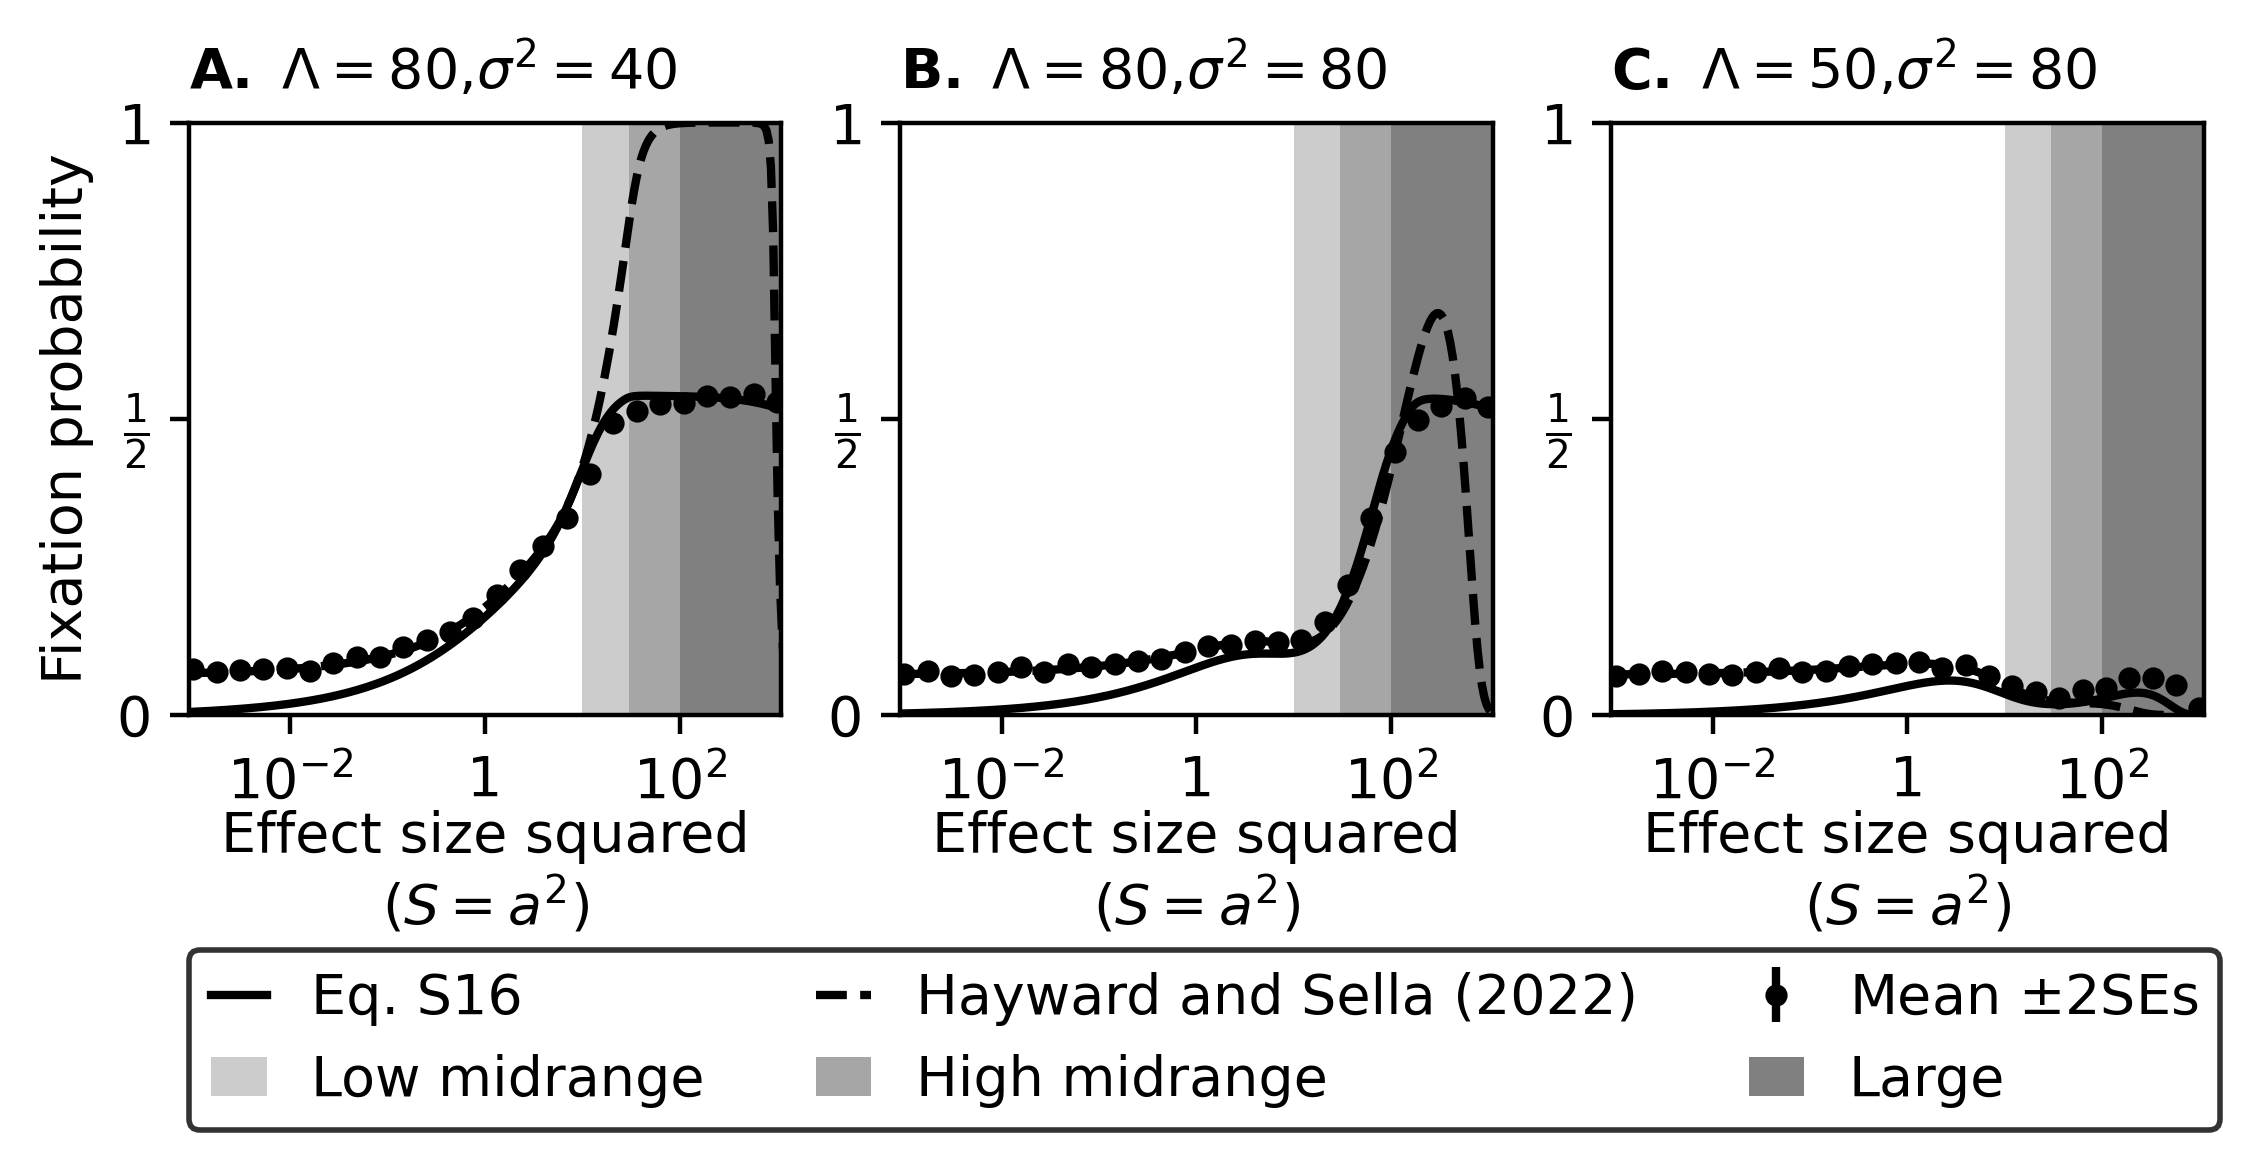

In [16]:
def create_figure(height):
    fontsize = 10
    N = 5000
    shift = 80
    sigma2 = 80
    # fig = plt.figure(dpi = 400, figsize = (5,5))
    fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(6.5,height),dpi=400)

    for shift,sigma2,ax,letter in zip([80,80,50],[40,80,80],axes,['A','B','C']):
        
    
        results_temp = simulated_results[shift][sigma2]
        plt.sca(ax)
        
        for S in results_temp.keys():
            
            for sign in results_temp[S].keys():                
                n_fix,n = results_temp[S][sign]
                    
                if n > 0:
                    p = n_fix/n
                    plt.errorbar(S,p,(p*(1-p)/n)**0.5*2,marker='.',color='k')
                
        for sign in [1]:
            
            
            S_values = np.logspace(-2,4,300)

            for mode,ls in zip(['ss','will'],['--','-']):
                y1 = []
                for S in S_values:
                    y1.append(fixation_prob_given_S(S=S,sign=sign,sigma2=sigma2,shift=shift,mode=mode))
                S_values,y1,ls = theoretical_results[shift][sigma2][sign][mode]
                plt.plot(S_values,y1,color='k',ls=ls)
            

        plt.xscale('log')
        plt.xlabel('Effect size squared\n'+r'($S=a^2$)',fontsize=fontsize,labelpad=0)
        plt.ylabel('')
        plt.ylim([0,1])
        plt.xlim([0.9e-3,1e3/0.9])
        ax.set_xticks([0.01,1,100])
        ax.set_xticklabels([r'$10^{-2}$','1',r'$10^2$'])
        ax.set_yticks([0.0,0.5,1])
        ax.set_yticklabels([r'$0$',r'$\frac{1}{2}$',r'$1$'])
        line1, = plt.plot([],[],color='k',ls='-',label='Eq. S16')
        line2, = plt.plot([],[],color='k',ls='--',label='Hayward and Sella (2022)')
        line3 = plt.errorbar([],[],[],color='k',ls='',marker='.',label=r'Mean $\pm 2$SEs')
        if letter == 'A':
            title = r'$\bf{A.}$ ' 
        elif letter == 'B':
            title = r'$\bf{B.}$ '
        elif letter == 'C':
            title = r'$\bf{C.}$ '  
            
        # title = title + 'Fixation probability given \n'+r'$\Lambda = $'+f'{shift},'+r'$\sigma^2 = $'+f'{sigma2}'
        title = title + r'$\Lambda = $'+f'{shift},'+r'$\sigma^2 = $'+f'{sigma2}'
        plt.title(title,fontsize=fontsize,loc='left')
        
        box1 = plt.fill_between([10,30],[0,0],[1,1],color=[0.8]*3,edgecolor='None',label='Low midrange')
        box2 = plt.fill_between([30,100],[0,0],[1,1],color=[0.65]*3,edgecolor='None',label='High midrange')
        box3 = plt.fill_between([100,2000],[0,0],[1,1],color=[0.5]*3,edgecolor='None',label='Large')

        if letter == 'A':
            plt.legend(handles = [line1,box1,line2,box2,line3,box3],edgecolor='k',ncols=3,loc = (0,-0.7),handlelength=1,fontsize=fontsize)
        

    axes[0].set_ylabel('Fixation probability',fontsize=fontsize)
    # Adjust layout
    plt.subplots_adjust(wspace=0.2)
    bbox = axes[0].get_window_extent()
    # Convert the bounding box to inches using the figure's DPI
    width_inches = bbox.width / fig.dpi
    height_inches = bbox.height / fig.dpi
    print(width_inches,height_inches,height)
    if not np.isclose(width_inches,height_inches,rtol=0.01):
        height_inches = height*width_inches/height_inches
        square = False
    else:
        square = True
    return square,fig,height_inches

square = False
height = 2.8
while not square:
    square,fig,height = create_figure(height)
    if not square:
        plt.close()
plt.savefig('/burg-archive/home/wm2377/cdwm/snakemake_versions/Figure_S11/Figure_S11.png',dpi=300,bbox_inches='tight')
